Paper: https://arxiv.org/abs/1705.05363

Paper notes:

ICM consists of two models: forward and inverse model


In [6]:
import gym
import math
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.utils import clip_grad_norm_
from collections import deque


In [11]:
env_name = "CartPole-v0"
env = gym.make(env_name)


print("action space: ", env.action_space.n)
print("observation space ", env.env.observation_space.shape[0])
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using: ", device)

GAMMA = 0.99
ETA = 1.    # Scaling factor for the influence of the intrinsic Reward
BETA = 0.2
SCALAR_BETA = 0.1
EXTRINSIC_REWARD = False
ENTROPY_BONUS = 0.0001
LAMBDA = 0.95
CLIP_GRAD = .1
C_LR = 4e-4
A_LR = 4e-4

HIDDEN_SIZE = 64

class Critic(nn.Module):
    def __init__(self, input_shape):
        super(Critic, self).__init__()
        self.net = nn.Sequential(nn.Linear(input_shape, HIDDEN_SIZE),
                                 nn.ReLU(),
                                 nn.Linear(HIDDEN_SIZE,HIDDEN_SIZE),
                                 nn.ReLU(),
                                 nn.Linear(HIDDEN_SIZE, 1))
    
    def forward(self,x):
        x = self.net(x)
        return x
      
class Actor(nn.Module):
    def __init__(self, input_shape, output_shape):
        super(Actor, self).__init__()
        self.net = nn.Sequential(nn.Linear(input_shape, HIDDEN_SIZE),
                                 nn.ReLU(),
                                 nn.Linear(HIDDEN_SIZE,HIDDEN_SIZE),
                                 nn.ReLU(),
                                 nn.Linear(HIDDEN_SIZE, output_shape),
                                 nn.Softmax(dim=1)
                                 )

    def forward(self, x):
        probs = self.net(x)    
        dist = Categorical(probs)
        actions = dist.sample()
        logprobs = dist.log_prob(actions) 
    
        return actions, logprobs, dist
    

    
class Encoder(nn.Module): 
    def __init__(self, state_size, enc_state_size=12, hidden_size=64):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(state_size, hidden_size),
                                     nn.ReLU(),
                                     nn.Linear(hidden_size, hidden_size),
                                     nn.ReLU(),
                                     nn.Linear(hidden_size, enc_state_size))
  
    def forward(self,x):
        return self.encoder(x)

class Inverse(nn.Module):
    """
    1. (first submodel) encodes the state and next state into feature space.
    2. (second submodel) the inverse approximates the action taken by the given state and next state in feature size
    
    returns the predicted action and the encoded state for the Forward Model and the encoded next state to train the forward model!
    
    optimizing the Inverse model by the loss between actual action taken by the current policy and the predicted action by the inverse model
    """
    def __init__(self, action_size, enc_state_size, hidden_size=64):
        super(Inverse, self).__init__()
        self.inverse = nn.Sequential(nn.Linear(enc_state_size*2, hidden_size),
                                     nn.ReLU(),
                                     nn.Linear(hidden_size, hidden_size),
                                     nn.ReLU(),
                                     nn.Linear(hidden_size, action_size),
                                     nn.Softmax(dim=1))
    def forward(self, state1,state2):
        x = torch.cat( (state1, state2), dim=1)
        return self.inverse(x)

    
class Forward(nn.Module):
  """
  
  """
    def __init__(self, enc_state_size, OHE_size=12, hidden_size=64):
        super(Forward, self).__init__()
        self.OHE_size = OHE_size
        self.forwardM = nn.Sequential(nn.Linear(enc_state_size+self.OHE_size, hidden_size),
                                      nn.ReLU(),
                                      nn.Linear(hidden_size, hidden_size),
                                      nn.ReLU(),
                                      nn.Linear(hidden_size,enc_state_size))
    
    def forward(self,state,action):
        """
        Gets as inputs the aciton taken from the policy and the encoded state by the encoder in the inverse model.
        The froward model trys to predict the encoded next state. 
        Returns the predicted encoded next state.
        Gets optimized by the MSE between the actual encoded next state and the predicted version of the forward model!

         """
        action_ = torch.zeros(action.shape[0],self.OHE_size) # 2024,OHE
        indices = torch.stack( (torch.arange(action.shape[0]), action.squeeze().long()), dim=0)
        indices = indices.tolist()
        action_[indices] = 1.
        x = torch.cat( (state,action_) ,dim=1)
        return self.forwardM(x)

    
def ICM(state1, action, state2, forward_scale=1., inverse_scale=1e4):
  """
  
  """
  state1_hat = encoder(state1) 
  state2_hat = encoder(state2)
  
  state2_hat_pred = forwardM(state1_hat.detach(), action.detach()) 
  forward_pred_err = forward_scale * forward_loss(state2_hat_pred, state2_hat.detach()).sum(dim=1).unsqueeze(dim=1)
  pred_action = inverse(state1_hat, state2_hat) 
  

  inverse_pred_err = inverse_scale * inverse_loss(pred_action, action.detach().flatten().long()).unsqueeze(dim=1)    
  return forward_pred_err, inverse_pred_err

action space:  2
observation space  4
Using:  cpu


In [0]:
def test_net( count = 10):
    rewards = 0.0
    steps = 0
    entropys = 0.0
    for _ in range(count):
        obs = env.reset()

        while True:
            obs_v = torch.from_numpy(obs).unsqueeze(0).float()
            action, _, dist = actor(obs_v.to(device))
            entropy = dist.entropy().detach().cpu().numpy()
            obs, reward, done, info = env.step(action[0].cpu().numpy())
            
            rewards += reward
            entropys += entropy.mean()
            steps += 1
            if done:
                break

    return rewards/count, entropys/count, steps/count
  
  
  

def compute_gae(next_value, rewards, masks, values, gamma=GAMMA, lambda_=LAMBDA):
    """
    lambda => 1: high variance, low bias
    lambda => 0: low variance, high bias
    """
    values.append(next_value)
    gae = 0
    disc_returns = []
    advantage = []
    for step in reversed(range(len(rewards))):
        # d = r_t +gamma*V(s_t+1) - V(s)
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
        # sum(lambda*gamma)^t* delta_t+1
        gae = delta + gamma * lambda_ * masks[step] * gae
        
        disc_returns.insert(0, gae + values[step]) # adding values since we want the returns and not the advantage yet!  A(a,s) = Q"returns" - V(s)
        advantage.insert(0, gae)
        
    return torch.FloatTensor(disc_returns).unsqueeze(1), torch.FloatTensor(advantage).unsqueeze(1)

  
def ppo_iter(mini_batch_size, states, actions, log_probs, advantage, discounted_rewards, curiosity_loss):
    batch_size = len(states)
    #print(batch_size)
    for i in range(batch_size // mini_batch_size):
        rand_ids = np.random.randint(0, batch_size, mini_batch_size)
        
        yield torch.cat(states)[rand_ids], torch.cat(actions)[rand_ids], torch.cat(log_probs)[rand_ids], advantage[rand_ids], discounted_rewards[rand_ids], curiosity_loss[rand_ids]
        
        

def ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, advantage, discounted_rewards, curiosity_loss, eps_clip=0.2):
  """
  
  """

  a_loss_batch = []
  c_loss_batch = []
  icm_loss_batch = []

  for _ in range(ppo_epochs):
    for states_i, old_actions, old_logprobs, advantage_i, discounted_reward_i, cur_loss  in ppo_iter(mini_batch_size, states, actions, log_probs, advantage, discounted_rewards, curiosity_loss):

      optimizer.zero_grad()
      #c_optimizer.zero_grad()
      #tran critic
      new_value = critic(states_i.to(device))
      c_loss = .5 * F.mse_loss(new_value, discounted_reward_i)
      #clip_grad_norm_(critic.parameters(),CLIP_GRAD)
      #c_loss.backward()
      #c_optimizer.step()
      
      c_loss_batch.append(c_loss.detach().numpy())
      
      
      #train actor
      #a_optimizer.zero_grad()
      _, _, dist = actor(states_i.to(device))
      new_logprobs = dist.log_prob(old_actions)
      entropy = dist.entropy().mean()

      ratio = torch.exp(new_logprobs - old_logprobs.detach())
      surr = ratio * advantage_i
      clip = torch.clamp(ratio, 1.0 - eps_clip, 1.0 + eps_clip) 
      a_loss  = - (torch.min(surr, clip*advantage_i).mean()) + ENTROPY_BONUS * entropy
      #clip_grad_norm_(actor.parameters(),CLIP_GRAD)
      #a_loss.backward()
      #a_optimizer.step()
      a_loss_batch.append(a_loss.detach().numpy())
      
      #train icm
      #icm_optimizer.zero_grad()
      cur_loss = cur_loss.mean()
      #cur_loss.backward(retain_graph=True)
      #icm_optimizer.step()
      
      icm_loss_batch.append(cur_loss.detach().numpy())
      
      #when calculated combined loss:
      overall_loss = SCALAR_BETA * (c_loss + a_loss) + cur_loss
      overall_loss.backward(retain_graph=True)
      optimizer.step()
      


     
  return np.array(c_loss_batch).mean(), np.array(a_loss_batch).mean(), np.array(icm_loss_batch)

Episode: 550 | Ep_Reward: 170.10 | Average_100: 72.51

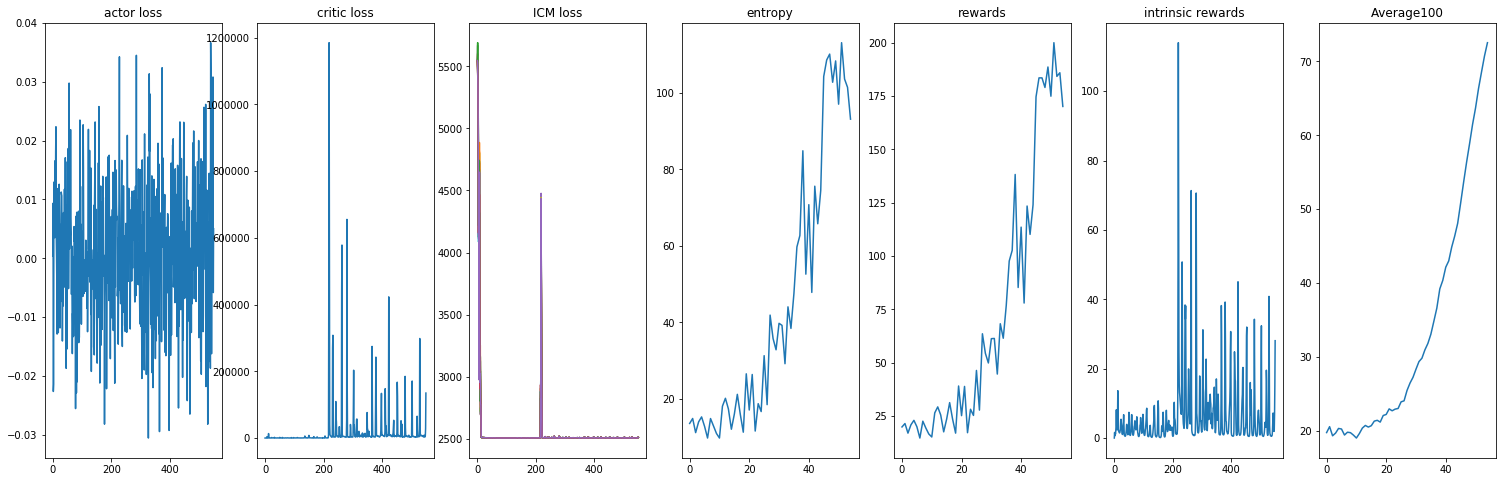

In [20]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
env.seed(42)

input_shape  = env.observation_space.shape[0]
output_shape = env.action_space.n

actor = Actor(input_shape, output_shape).to(device)
critic = Critic(input_shape).to(device)


encoder = Encoder(state_size=input_shape, enc_state_size=2)
inverse = Inverse(action_size=output_shape, enc_state_size=2)
forwardM = Forward(enc_state_size=2, OHE_size=2)

forward_loss = nn.MSELoss(reduction='none')
inverse_loss = nn.CrossEntropyLoss(reduction='none')


all_parameters = list(actor.parameters())+list(critic.parameters())+list(encoder.parameters())+list(inverse.parameters())+list(forwardM.parameters())
optimizer = optim.RMSprop(params=all_parameters, lr=A_LR)

# a_optimizer = optim.RMSprop(params=actor.parameters(), lr=A_LR)
# c_optimizer = optim.RMSprop(params=critic.parameters(), lr=C_LR)
# icm_params = list(encoder.parameters())+list(inverse.parameters())+list(forwardM.parameters())
# icm_optimizer = optim.Adam(params=icm_params, lr = 1e-3)

max_episodes = 550


c_loss_list = []
a_loss_list = []
icm_loss_list = []
entropy_list = []
intrinsic_rewards = []

average_100 = []
plot_rewards = []
max_steps = 2024

for ep in range(max_episodes+1):
    state = env.reset()
    done = False
    
    state_batch = []
    next_state_batch = []
    value_batch = []
    action_batch = []
    logprob_batch = []
    rewards_batch = []
    masks = []
    for step in range(max_steps):

        state = torch.from_numpy(state).unsqueeze(0).float()
        action, logprob, _  = actor(state.to(device))  
        value = critic(state.to(device))
        next_state, reward, done, _ = env.step(action[0].cpu().numpy())
        
        state_batch.append(state)
        next_state_batch.append(torch.from_numpy(next_state).unsqueeze(0).float())
        value_batch.append(value.item())
        logprob_batch.append(logprob)
        action_batch.append(action)
        rewards_batch.append(reward)  
        masks.append(1 - done)

        state = next_state

        if done:
          state = env.reset()

       
    # Intrinsic Curiosity Calculation
    state1_batch = torch.cat(state_batch)
    state2_batch = torch.cat(next_state_batch)
    actions_batch = torch.cat(action_batch)
    forward_pred_err, inverse_pred_err = ICM(state1_batch, actions_batch, state2_batch)
    rewards = ((1. / ETA) * forward_pred_err).detach()
   
    intrinsic_rewards.append(rewards.mean().numpy())
    if EXTRINSIC_REWARD == True:
        rewards += torch.FloatTensor(rewards_batch).unsqueeze(1)

    rewards_batch = list(rewards)  
    curiosity_loss = (1 - BETA) * inverse_pred_err + (BETA * forward_pred_err)

    # calculate advantage:
    next_value = critic(torch.from_numpy(next_state).unsqueeze(0).float()).item()
    discounted_rewards, advantage = compute_gae(next_value, rewards_batch, masks, value_batch)
    # normalize advantage:
    advantage = (advantage - advantage.mean()) / (advantage.std() + 1e-5)
    
    c_loss, a_loss, icm_loss = ppo_update(ppo_epochs = 5, mini_batch_size = 512, states = state_batch, actions = action_batch, log_probs = logprob_batch, advantage = advantage, discounted_rewards = discounted_rewards, curiosity_loss=curiosity_loss)
    c_loss_list.append(c_loss)
    a_loss_list.append(a_loss)
    icm_loss_list.append(icm_loss)
    
    
    if ep != 0 and ep % 10 == 0:
        test_rewards, test_entropy, test_steps = test_net()
        entropy_list.append(test_entropy)
        plot_rewards.append(test_rewards)

        average_100.append(np.mean(plot_rewards[-100:]))
        print("\rEpisode: {} | Ep_Reward: {:.2f} | Average_100: {:.2f}".format(ep, test_rewards, np.mean(plot_rewards[-100:])), end = "", flush = True)
        
        

    

# PLOTTING RESULTS

plt.figure(figsize = (26,8))
plt.subplot(1,7,1)
plt.title("actor loss")
plt.plot(a_loss_list)
plt.subplot(1,7,2)
plt.title("critic loss")
plt.plot(c_loss_list)
plt.subplot(1,7,3)
plt.title("ICM loss")
plt.plot(icm_loss_list)
plt.subplot(1,7,4)
plt.title("entropy")
plt.plot(entropy_list)
plt.subplot(1,7,5)
plt.title("rewards")
plt.plot(plot_rewards)
plt.subplot(1,7,6)
plt.title("intrinsic rewards")
plt.plot(intrinsic_rewards)
plt.subplot(1,7,7)
plt.title("Average100")
plt.plot(average_100)
plt.show()